In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
import networkx as nx
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import wasserstein_distance
import copy

In [3]:
def create_plot_network(G,N,opinions,vmin,vmax,figtitle,simstr,savef=False):
# Create network for visualization
    edges=[]
    for i in range(N):
        for j in range(i):
            if G[i,j]==1:
                edges.append((i,j))

    cmap = plt.cm.viridis # plt.cm.hot #
    G2 = nx.Graph()
    G2.add_nodes_from(np.arange(0,N))
    G2.add_edges_from(edges)
    pos = nx.spring_layout(G2,seed=10)    
    
 
    plt.figure()
    edgesdraw = nx.draw_networkx_edges(G2, pos, alpha=0.4)
    nodesdraw = nx.draw_networkx_nodes(G2, pos, node_color=opinions, cmap=cmap, node_size=50, vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.ax.tick_params(labelsize=15)
    if savef:
        plt.savefig('figs_verification/' + simstr + figtitle + '.png',dpi=600)

In [4]:
def OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T):
       
    titleplot= 'time = 0' 
    create_plot_network(G, N, opinions, -1, 1, titleplot, simstr, savef=True)
    plt.show()
    plt.close('all')
    
    dist_opinions=np.zeros(200) # how many iterations used to say that the system has become stable
    dist_opinions[-1]=1
    k=0
    
    
    while (not all(dist_opinions<0.003) and k < nrtime):
        temp_opinion=copy.deepcopy(opinions)
        # step 1: remove neighbors with opdiff>0.5 
        for ind in range(N):
            opnb = opinions*G[ind] # opinions of neighbors
            myop = opinions[ind]*G[ind] #agent's own opinion at location of neighbors
            distop = abs(myop - opnb) # distance of agent's opinion to it's neighbors
            idx=np.where(distop>dist_removelink)[0] # locations where opinion distance higher than dist_removelink
            for j in range(len(idx)):
                if (np.random.uniform(0,1)<prob_removelink and sum(G[ind])>1 and sum(G[idx[j]])>1):
                    G[ind,idx[j]]=0
                    G[idx[j],ind]=0
                    
            # step 2: make new connections
            for j in range(tries_createlink):
                if sum(G[ind])<maxnb:
                    newnb=np.random.randint(0,N) # possible new neighbor
                    while (newnb == ind):
                        newnb=np.random.randint(0,N) # don't pick yourself
                    if abs(opinions[newnb]-opinions[ind])<dist_createlink and G[ind,newnb]==0 and sum(G[newnb]<maxnb):
                        if np.random.uniform(0,1)<prob_createlink:
                            G[ind, newnb] = 1
                            G[newnb, ind] = 1
        
        # step 3: change values
        for j in range(tries_valuechange):
            ind = np.random.randint(0,N)
            valnb = values*G[ind]
            optval = sum(valnb)/sum(abs(valnb)>0)
            distval = optval - values[ind]
            values[ind] = values[ind] + rate_valuechange * distval
                    
        # step 4: change opinions
        for j in range(tries_opinionchange): #2        
            ind = np.random.randint(0,N)
            if np.random.rand() < 1-stubbornness[ind]: # go into opinion-change procedure dependent on stubbornness
                randnew = np.random.rand(1)*2-1 # random new opinion
                opnb = opinions*G[ind] # opinion of neighbors
                distnb=abs(values-values[ind]) #value distance to neighbors
                valuesigns = (G[ind]*[distnb>distcd])[0]*2 # 2 if distnb > distcd, 0 if distnb < distcd
                Eold = sum(abs(valuesigns-abs(opinions[ind]*G[ind] - opnb))*persuasiveness) 
                Enew = sum(abs(valuesigns-abs(randnew*G[ind] - opnb))*persuasiveness)
                dH = Enew - Eold
                if dH < 0:
                    opinions[ind] = randnew
                elif np.random.rand() < exp(-dH/T):
                    opinions[ind]  = randnew
        
        dist_opinions[:-1] = dist_opinions[1::]
        dist_opinions[-1] = wasserstein_distance(opinions,temp_opinion)
                     
        k += 1
        
    titleplot= 'time = ' + str(k)
    create_plot_network(G, N, opinions, -1, 1, titleplot, simstr, savef=True)
    plt.show()
    plt.close('all')
            
    plt.figure()
    my_kde = sns.kdeplot(data=opinions, color='b', bw_adjust=0.9)
    plt.xlim(-1,1)
    line = my_kde.lines[0]
    x, y = line.get_data()
    nrpeaks = len(find_peaks(y,height=max(y)/10,prominence=0.1)[0])
    if nrpeaks==1:
        if np.var(opinions)<0.05:
            categories=0
        else:
            categories=1
    elif nrpeaks==2:
        categories=2
    else:
        categories=3
    plt.close('all')
    return opinions, G, categories, dist_opinions

# Test submodule 1

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jelle\\Documents\\coding-scripts\\thesisGSS\\og-model\\figs_verification\\mod1time = 0.png'

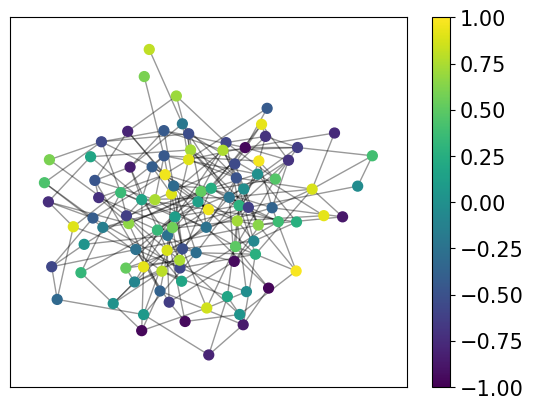

In [5]:
np.random.seed(0)

#Initialization
N=100
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

# set parameters
simstr='mod1'
nrtime=2000
dist_removelink = 0.6
prob_removelink = 0.1 
tries_createlink = 0 
dist_createlink = 0.1 
prob_createlink = 0.1 
maxnb = 10 
tries_valuechange = 0
rate_valuechange = 0.05
tries_opinionchange = 0
distcd=1
T=0.1

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

opinions, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)

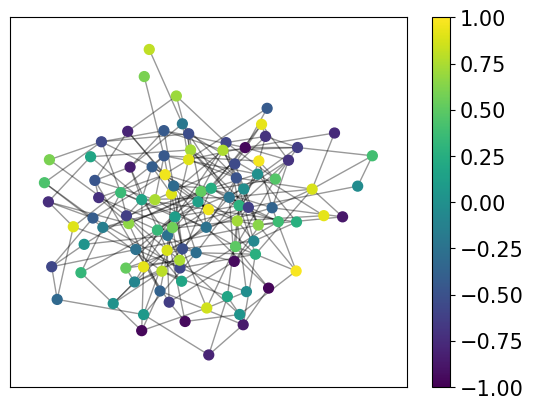

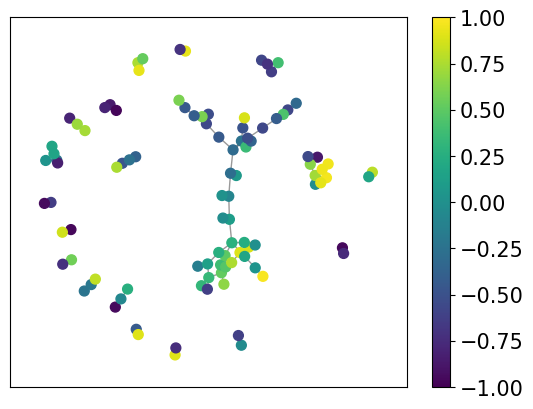

In [21]:
np.random.seed(0)

#Initialization
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

simstr='mod1_extr'
dist_removelink = 0.25
prob_removelink = 0.1 
tries_createlink = 0 
dist_createlink = 0.1 
prob_createlink = 0.1 
maxnb = 10 
tries_valuechange = 0
rate_valuechange = 0.05
tries_opinionchange = 0
distcd=1
T=0.1


opinions, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)

# Test submodule 2

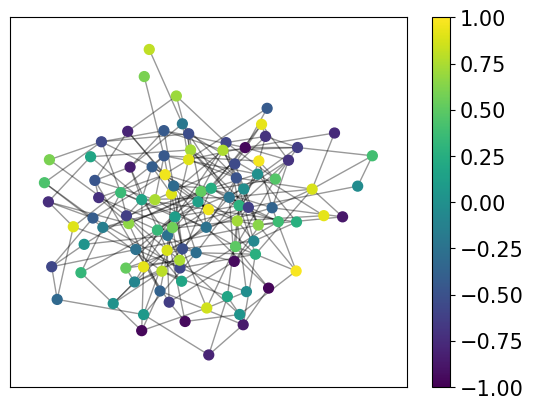

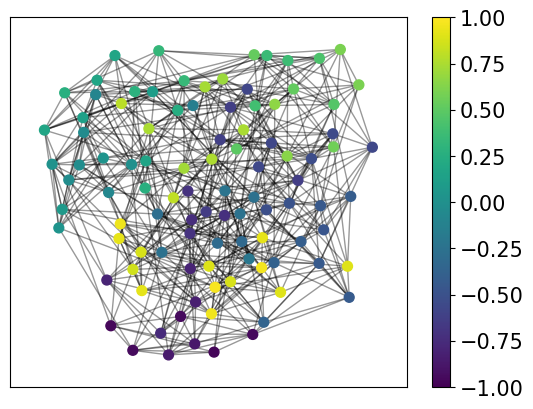

In [22]:
np.random.seed(0)

#Initialization
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

simstr='mod2_def'
dist_removelink = 0.6
prob_removelink = 0 
tries_createlink = 10 
dist_createlink = 0.1 
prob_createlink = 0.1 
maxnb = 10 
tries_valuechange = 0
rate_valuechange = 0.05
tries_opinionchange = 0
distcd=1
T=0.1


opinions, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)

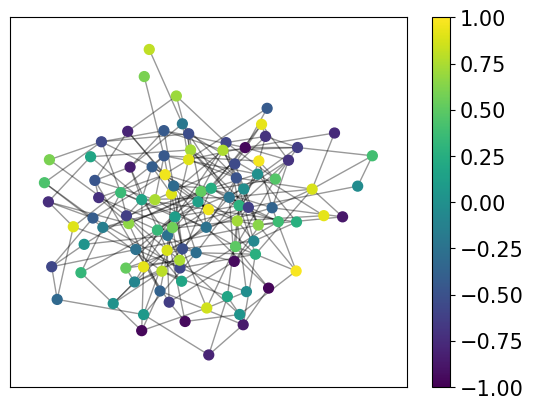

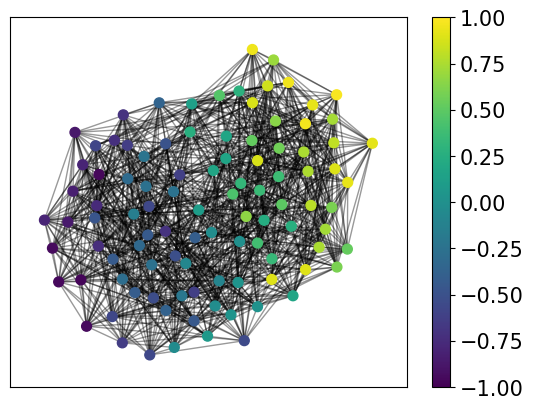

In [23]:
np.random.seed(0)

#Initialization
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

simstr='mod2_extr'
dist_removelink = 0.6
prob_removelink = 0 
tries_createlink = 10 
dist_createlink = 0.8 
prob_createlink = 0.1 
maxnb = 20 
tries_valuechange = 0
rate_valuechange = 0.05
tries_opinionchange = 0
distcd=1
T=0.1


opinions, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)

# Test submodule 3

In [27]:
def create_plot_network(G,N,opinions,vmin,vmax,figtitle,simstr,savef=False):
# Create network for visualization
    edges=[]
    for i in range(N):
        for j in range(i):
            if G[i,j]==1:
                edges.append((i,j))

    cmap = plt.cm.hot # plt.cm.viridis #
    G2 = nx.Graph()
    G2.add_nodes_from(np.arange(0,N))
    G2.add_edges_from(edges)
    pos = nx.spring_layout(G2,seed=10)    
    
 
    plt.figure()
    edgesdraw = nx.draw_networkx_edges(G2, pos, alpha=0.4)
    nodesdraw = nx.draw_networkx_nodes(G2, pos, node_color=opinions, cmap=cmap, node_size=50, vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.ax.tick_params(labelsize=15)
    #plt.title(figtitle)
    if savef:
        plt.savefig('figs_verification/' + simstr + figtitle + '.png',dpi=600)

In [28]:
def OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T):
       
    titleplot= 'time = 0' 
    create_plot_network(G, N, values, -1, 1, titleplot, simstr, savef=True)
    plt.show()
    plt.close('all')
    
    dist_opinions=np.zeros(200) # how many iterations used to say that the system has become stable
    dist_opinions[-1]=1
    k=0
    
    
    while (not all(dist_opinions<0.003) and k < nrtime):
        temp_opinion=copy.deepcopy(opinions)
        # step 1: remove neighbors with opdiff>0.5 
        for ind in range(N):
            opnb = opinions*G[ind] # opinions of neighbors
            myop = opinions[ind]*G[ind] #agent's own opinion at location of neighbors
            distop = abs(myop - opnb) # distance of agent's opinion to it's neighbors
            idx=np.where(distop>dist_removelink)[0] # locations where opinion distance higher than dist_removelink
            for j in range(len(idx)):
                if (np.random.uniform(0,1)<prob_removelink and sum(G[ind])>1 and sum(G[idx[j]])>1):
                    G[ind,idx[j]]=0
                    G[idx[j],ind]=0
                    
            # step 2: make new connections
            for j in range(tries_createlink):
                if sum(G[ind])<maxnb:
                    newnb=np.random.randint(0,N) # possible new neighbor
                    while (newnb == ind):
                        newnb=np.random.randint(0,N) # don't pick yourself
                    if abs(opinions[newnb]-opinions[ind])<dist_createlink and G[ind,newnb]==0 and sum(G[newnb]<maxnb):
                        if np.random.uniform(0,1)<prob_createlink:
                            G[ind, newnb] = 1
                            G[newnb, ind] = 1
        
        # step 3: change values
        for j in range(tries_valuechange):
            ind = np.random.randint(0,N)
            valnb = values*G[ind]
            optval = sum(valnb)/sum(abs(valnb)>0)
            distval = optval - values[ind]
            values[ind] = values[ind] + rate_valuechange * distval
                    
        # step 4: change opinions
        for j in range(tries_opinionchange): #2        
            ind = np.random.randint(0,N)
            if np.random.rand() < 1-stubbornness[ind]: # go into opinion-change procedure dependent on stubbornness
                randnew = np.random.rand(1)*2-1 # random new opinion
                opnb = opinions*G[ind] # opinion of neighbors
                distnb=abs(values-values[ind]) #value distance to neighbors
                valuesigns = (G[ind]*[distnb>distcd])[0]*2 # 2 if distnb > distcd, 0 if distnb < distcd
                Eold = sum(abs(valuesigns-abs(opinions[ind]*G[ind] - opnb))*persuasiveness) 
                Enew = sum(abs(valuesigns-abs(randnew*G[ind] - opnb))*persuasiveness)
                dH = Enew - Eold
                if dH < 0:
                    opinions[ind] = randnew
                elif np.random.rand() < exp(-dH/T):
                    opinions[ind]  = randnew
        
        dist_opinions[:-1] = dist_opinions[1::]
        dist_opinions[-1] = wasserstein_distance(opinions,temp_opinion)
                     
        k += 1
        
    titleplot= 'time = ' + str(k)
    create_plot_network(G, N, values, -1, 1, titleplot, simstr, savef=True)
    plt.show()
    plt.close('all')
            
    plt.figure()
    my_kde = sns.kdeplot(data=opinions, color='b', bw_adjust=0.9)
    plt.xlim(-1,1)
    line = my_kde.lines[0]
    x, y = line.get_data()
    nrpeaks = len(find_peaks(y,height=max(y)/10,prominence=0.1)[0])
    if nrpeaks==1:
        if np.var(opinions)<0.05:
            categories=0
        else:
            categories=1
    elif nrpeaks==2:
        categories=2
    else:
        categories=3
    plt.close('all')
    return opinions, G, categories, dist_opinions

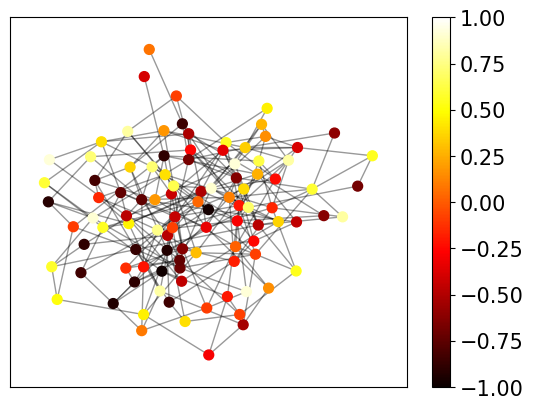

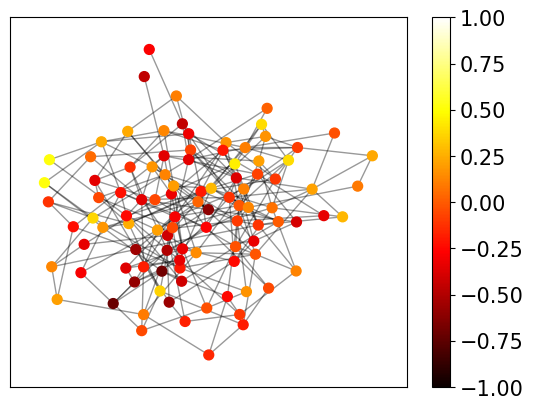

In [29]:
np.random.seed(0)

#Initialization
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

simstr='mod3'
dist_removelink = 0.6
prob_removelink = 0 
tries_createlink = 0 
dist_createlink = 0.1 
prob_createlink = 0.1 
maxnb = 10 
tries_valuechange = 10
rate_valuechange = 0.05
tries_opinionchange = 0
distcd=1
T=0.1


opinions, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)

# Test submodule 4

In [18]:
def create_plot_network(G,N,opinions,vmin,vmax,figtitle,simstr,savef=False):
# Create network for visualization
    edges=[]
    for i in range(N):
        for j in range(i):
            if G[i,j]==1:
                edges.append((i,j))

    cmap = plt.cm.viridis # plt.cm.hot #
    G2 = nx.Graph()
    G2.add_nodes_from(np.arange(0,N))
    G2.add_edges_from(edges)
    pos = nx.spring_layout(G2,seed=10)    
    
 
    plt.figure()
    edgesdraw = nx.draw_networkx_edges(G2, pos, alpha=0.4)
    nodesdraw = nx.draw_networkx_nodes(G2, pos, node_color=opinions, cmap=cmap, node_size=50, vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    cbar = plt.colorbar(sm)
    cbar.ax.tick_params(labelsize=15)
    #plt.title(figtitle)
    if savef:
        plt.savefig('figs_verification/' + simstr + figtitle + '.png',dpi=600)

In [17]:
def OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T):
       
    titleplot= 'time = 0' 
    create_plot_network(G, N, opinions, -1, 1, titleplot, simstr, savef=True)
    plt.show()
    plt.close('all')
    
    dist_opinions=np.zeros(200) # how many iterations used to say that the system has become stable
    dist_opinions[-1]=1
    k=0
    
    
    while (not all(dist_opinions<0.003) and k < nrtime):
        temp_opinion=copy.deepcopy(opinions)
        # step 1: remove neighbors with opdiff>0.5 
        for ind in range(N):
            opnb = opinions*G[ind] # opinions of neighbors
            myop = opinions[ind]*G[ind] #agent's own opinion at location of neighbors
            distop = abs(myop - opnb) # distance of agent's opinion to it's neighbors
            idx=np.where(distop>dist_removelink)[0] # locations where opinion distance higher than dist_removelink
            for j in range(len(idx)):
                if (np.random.uniform(0,1)<prob_removelink and sum(G[ind])>1 and sum(G[idx[j]])>1):
                    G[ind,idx[j]]=0
                    G[idx[j],ind]=0
                    
            # step 2: make new connections
            for j in range(tries_createlink):
                if sum(G[ind])<maxnb:
                    newnb=np.random.randint(0,N) # possible new neighbor
                    while (newnb == ind):
                        newnb=np.random.randint(0,N) # don't pick yourself
                    if abs(opinions[newnb]-opinions[ind])<dist_createlink and G[ind,newnb]==0 and sum(G[newnb]<maxnb):
                        if np.random.uniform(0,1)<prob_createlink:
                            G[ind, newnb] = 1
                            G[newnb, ind] = 1
        
        # step 3: change values
        for j in range(tries_valuechange):
            ind = np.random.randint(0,N)
            valnb = values*G[ind]
            optval = sum(valnb)/sum(abs(valnb)>0)
            distval = optval - values[ind]
            values[ind] = values[ind] + rate_valuechange * distval
                    
        # step 4: change opinions
        for j in range(tries_opinionchange): #2        
            ind = np.random.randint(0,N)
            if np.random.rand() < 1-stubbornness[ind]: # go into opinion-change procedure dependent on stubbornness
                randnew = np.random.rand(1)*2-1 # random new opinion
                opnb = opinions*G[ind] # opinion of neighbors
                distnb=abs(values-values[ind]) #value distance to neighbors
                valuesigns = (G[ind]*[distnb>distcd])[0]*2 # 2 if distnb > distcd, 0 if distnb < distcd
                Eold = sum(abs(valuesigns-abs(opinions[ind]*G[ind] - opnb))*persuasiveness) 
                Enew = sum(abs(valuesigns-abs(randnew*G[ind] - opnb))*persuasiveness)
                dH = Enew - Eold
                if dH < 0:
                    opinions[ind] = randnew
                elif np.random.rand() < exp(-dH/T):
                    opinions[ind]  = randnew
        
        dist_opinions[:-1] = dist_opinions[1::]
        dist_opinions[-1] = wasserstein_distance(opinions,temp_opinion)
                     
        k += 1
        
    titleplot= 'time = ' + str(k)
    create_plot_network(G, N, opinions, -1, 1, titleplot, simstr, savef=True)
    plt.show()
    plt.close('all')
            
    plt.figure()
    my_kde = sns.kdeplot(data=opinions, color='b', bw_adjust=0.9)
    plt.xlim(-1,1)
    line = my_kde.lines[0]
    x, y = line.get_data()
    nrpeaks = len(find_peaks(y,height=max(y)/10,prominence=0.1)[0])
    if nrpeaks==1:
        if np.var(opinions)<0.05:
            categories=0
        else:
            categories=1
    elif nrpeaks==2:
        categories=2
    else:
        categories=3
    plt.close('all')
    return opinions, G, categories, dist_opinions

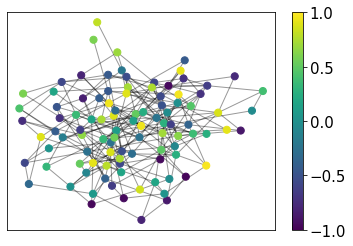

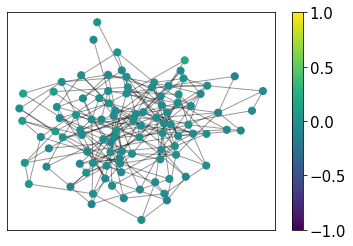

In [19]:
np.random.seed(0)

#Initialization
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

simstr='mod4_1'
dist_removelink = 0.6
prob_removelink = 0 
tries_createlink = 0 
dist_createlink = 0.1 
prob_createlink = 0.1 
maxnb = 10 
tries_valuechange = 0
rate_valuechange = 0
tries_opinionchange = 150
distcd=2
T=0.1

stubbornness = np.zeros(N) 
persuasiveness = np.ones(N)


opinions, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)

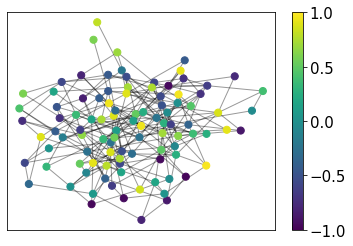

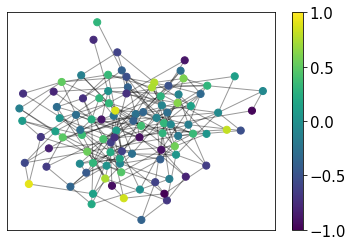

In [20]:
np.random.seed(0)

#Initialization
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

simstr='mod4_2'
dist_removelink = 0.6
prob_removelink = 0 
tries_createlink = 0 
dist_createlink = 0.1 
prob_createlink = 0.1 
maxnb = 10 
tries_valuechange = 0
rate_valuechange = 0
tries_opinionchange = 150
distcd=2
T=10

stubbornness = np.zeros(N) 
persuasiveness = np.ones(N)


opinions, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)

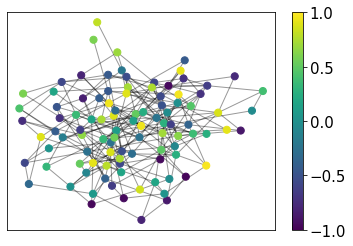

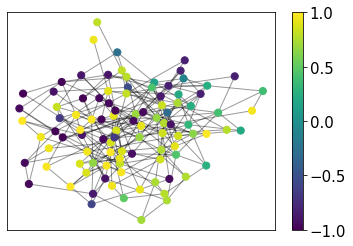

In [21]:
np.random.seed(0)

#Initialization
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

simstr='mod4_3'
dist_removelink = 0.6
prob_removelink = 0 
tries_createlink = 0 
dist_createlink = 0.1 
prob_createlink = 0.1 
maxnb = 10 
tries_valuechange = 0
rate_valuechange = 0
tries_opinionchange = 150
distcd=1
T=0.1

stubbornness = np.zeros(N) 
persuasiveness = np.ones(N)


opinions, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)

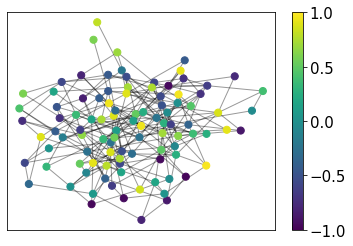

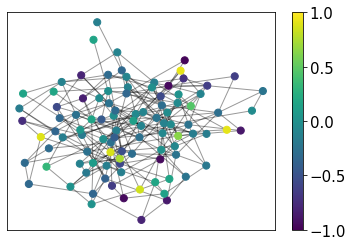

In [22]:
np.random.seed(0)

#Initialization
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

simstr='mod4_4'
dist_removelink = 0.6
prob_removelink = 0 
tries_createlink = 0 
dist_createlink = 0.1 
prob_createlink = 0.1 
maxnb = 10 
tries_valuechange = 0
rate_valuechange = 0
tries_opinionchange = 150
distcd=2
T=0.1

stubbornness = np.zeros(N) 
stubbornness[np.random.choice(N,50)]=1
persuasiveness = np.ones(N)


opinions, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)

In [1]:
np.random.seed(0)

#Initialization
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

simstr='mod4_5'
dist_removelink = 0.6
prob_removelink = 0 
tries_createlink = 0 
dist_createlink = 0.1 
prob_createlink = 0.1 
maxnb = 10 
tries_valuechange = 0
rate_valuechange = 0
tries_opinionchange = 150
distcd=2
T=0.1

stubbornness = np.zeros(N) 
persuasiveness = np.ones(N)
persuasiveness[np.random.choice(N,50)]=0

opinions, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)

NameError: name 'np' is not defined

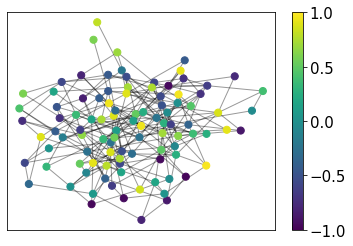

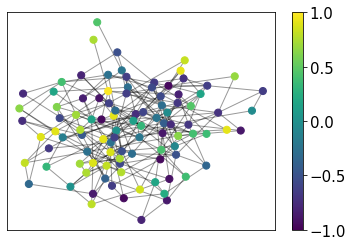

In [24]:
np.random.seed(0)

#Initialization
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

simstr='mod4_6'
dist_removelink = 0.6
prob_removelink = 0 
tries_createlink = 0 
dist_createlink = 0.1 
prob_createlink = 0.1 
maxnb = 10 
tries_valuechange = 0
rate_valuechange = 0
tries_opinionchange = 150
distcd=1
T=0.1

stubbornness[np.random.choice(N,50)]=1
persuasiveness[np.random.choice(N,50)]=0

opinions, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)